# Quantification

In [450]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import json
import os
import matplotlib.pyplot as plt

## Load Data

In [451]:
stock: pd.DataFrame = pd.read_pickle("../../data/TSLA.pkl")
stock

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-02,20.008667,20.579332,19.508667,19.950666,296871000
2017-11-03,19.966667,20.416668,19.675333,20.406000,133410000
2017-11-06,20.466667,20.500000,19.934000,20.185333,97290000
2017-11-07,20.068001,20.433332,20.002001,20.403334,79414500
2017-11-08,20.366667,20.459333,20.086666,20.292667,70879500
...,...,...,...,...,...
2022-10-26,219.399994,230.600006,218.199997,224.639999,85012500
2022-10-27,229.770004,233.809998,222.850006,225.089996,61638800
2022-10-28,225.399994,228.860001,216.350006,228.520004,69152400


Split training and test data sets:

In [452]:
num_days = 90
train_df = stock[:-num_days]
test_df = stock[-num_days:]

## Combine Stocks and News

Intuitively, the news information can only provide us with very vague information about the stock price. In fact, it is already good enough if today's news can tell us whether the stock price will increase tomorrow.

In [453]:
# shifted percentage change: (tomorrow - today) / today
train_df = train_df[["Close"]].pct_change().shift(-1).dropna()

# whether the stock price will increase compared with today's price
train_df = train_df > 0
train_df.rename(columns={"Close": "Will Go Up?"}, inplace=True)
train_df

,Will Go Up?
Date,
2017-11-02,True
2017-11-03,False
2017-11-06,True
2017-11-07,False
2017-11-08,False
...,...
2022-06-16,True
2022-06-17,True
2022-06-21,False


Now, we attach the news headline on each date to the data frame:

In [454]:
train_df["Headline"] = np.nan

for date in train_df.index:
    date_str = datetime.strftime(date, "%Y-%m-%d")
    news_filepath = os.path.join("../../data/news/", f"TSLA/{date_str}.json")
    
    if not os.path.exists(news_filepath):
        continue
    
    with open(news_filepath, "r") as f:
        news = json.load(f)
    
    train_df.loc[date, "Headline"] = news["Headline"]

train_df = train_df[["Headline", "Will Go Up?"]]
train_df

,Headline,Will Go Up?
Date,,
2017-11-02,"The GOP tax bill kills a $7,500 electric-vehic...",True
2017-11-03,Tesla hits bumps in pursuit of mass market,False
2017-11-06,Tesla Investors May Be Losing Patience,True
2017-11-07,Bloomberg,False
2017-11-08,Tesla buys Perbix industrial automation company,False
...,...,...
2022-06-16,Tesla to charge more for cars in United States...,True
2022-06-17,"Tesla Raises EV Prices By as Much as $6,000 USD",True
2022-06-21,Bloomberg,False


## Word Embedding

Our goal is to predict whether the stock price will go up tomorrow based on today's news. So, it can be treated as a **classification** problem, more precisely, a **binary classification** problem. That is, we want to find a mapping / decision rule:

$$
\text{News Headline (Text)} \mapsto \{\text{True}, \text{False}\}
$$

But the headlines consist of text data. Hence, we need to first transform or encode them to numerical data. This procedure is called **word embedding**.

Usually, we need to train an additional model for word embedding, which is quite troublesome. To reduce our workload, fortunately, there is a pretrained model prodived by the module `sentence_transformers` that is ready to use.

In [455]:
from sentence_transformers import SentenceTransformer

```{seealso}
Check the [document](https://www.sbert.net/#) of sentence_transformers for more information.
```

Encode the news headlines with the model `SentenceTransformer`:

In [456]:
# load pretrained model
headline_encoder = SentenceTransformer("all-MiniLM-L6-v2")

# encode news headlines to NumPy arrays
embeddings = headline_encoder.encode(train_df["Headline"].tolist())

print(f"embeddings.shape: {embeddings.shape}")
embeddings

embeddings.shape: (1167, 384)


array([[ 0.02502805,  0.05323019,  0.09939805, ..., -0.04196155,
         0.04668063,  0.05590457],
       [-0.01846967, -0.02873902,  0.03534317, ..., -0.13485262,
         0.01329796,  0.13287042],
       [ 0.02563943, -0.04956274,  0.04786101, ..., -0.07707552,
        -0.05291679,  0.0715071 ],
       ...,
       [-0.01015677,  0.00959312, -0.01810676, ..., -0.03960473,
         0.00950317,  0.05490932],
       [-0.07479677,  0.01877449,  0.07296403, ..., -0.08446505,
         0.02360164,  0.05853827],
       [ 0.01585246,  0.05186599,  0.07435998, ..., -0.07771911,
         0.01394665,  0.05791727]], dtype=float32)

As we can see, each headline is transformed to an array with length 384.

## Binary Classifier

As mentioned, we want to solve a classification problem, the simplest model is Scikit-learn's `SGDClassifier`, which implements a *linear* model with stochastic gradient descent (SGD) learning.

In [457]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

In terms of machine learning terminologies, each sample $(\mathbf{x}, y)$ consists of a vector $\mathbf{x}$ representing 384 features (encoded news headline) and a binary label $y \in \{\text{True}, \text{False}\}$.

Training data:

In [458]:
X_train = embeddings
y_train = train_df["Will Go Up?"].to_numpy()

Train the Model:

```{tip}
Since `SGDClassifier` applies stochastic gradient descent during the training process. To ensure reproduction of the expreiment result, we pass a random seed to the model.
```

In [459]:
SEED = 7008
# sgd_clf = SGDClassifier(random_state=SEED)
clf = SVC(C = 5, kernel="sigmoid")
clf.fit(X_train, y_train)

SVC(C=5, kernel='sigmoid')

## Training Performance

In [460]:
from sklearn.metrics import confusion_matrix

In [461]:
y_train_pred = clf.predict(X_train)
y_train_pred

array([ True, False, False, ...,  True, False,  True])

### Confusion Matrix

In [462]:
confusion_matrix(y_train, y_train_pred)

array([[238, 320],
       [256, 353]])

### ROC Curve

In [463]:
from sklearn.metrics import roc_curve, roc_auc_score

Plot the ROC curve:

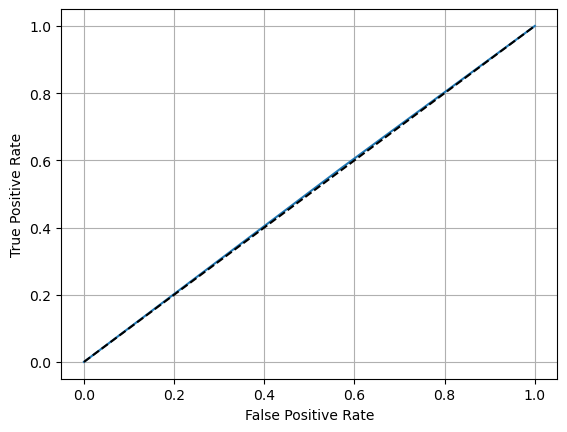

In [464]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

The area under the ROC curve (AUC):

In [465]:
roc_auc_score(y_train, y_train_pred)

0.5030810247717923

## Test Performance and Profit

Perform the same transformation on the test data set:

In [466]:
# whther price will go up the next day
test_df = test_df[["Close"]].pct_change().shift(-1).dropna()
test_df = test_df > 0
test_df.rename(columns={"Close": "Will Go Up?"}, inplace=True)

# attach news headlines
test_df["Headline"] = np.nan
for date in test_df.index:
    date_str = datetime.strftime(date, "%Y-%m-%d")
    news_filepath = os.path.join("../../data/news/", f"TSLA/{date_str}.json")
    
    if not os.path.exists(news_filepath):
        continue
    
    with open(news_filepath, "r") as f:
        news = json.load(f)
    
    test_df.loc[date, "Headline"] = news["Headline"]
test_df = test_df[["Headline", "Will Go Up?"]]

test_df

,Headline,Will Go Up?
Date,,
2022-06-27,You can now use CarPlay in your Tesla - and it...,False
2022-06-28,Tesla is cutting about 200 Autopilot jobs and ...,False
2022-06-29,Tesla lays off about 200 Autopilot workers and...,False
2022-06-30,Tesla Deliveries Are Coming. The ‘Line in the ...,True
2022-07-01,Bloomberg,True
...,...,...
2022-10-25,Tesla China price cuts ‘not unexpected’ say Ca...,True
2022-10-26,Exclusive: Tesla faces U.S. criminal probe ove...,True
2022-10-27,"From Tesla to SpaceX, what Elon Musk touches t...",True


In [467]:
X_test = headline_encoder.encode(test_df["Headline"].tolist())
y_test = test_df["Will Go Up?"].to_numpy()

Make prediction:

In [468]:
y_test_pred = clf.predict(X_test)

### Confusion Matrix

In [469]:
confusion_matrix(y_test, y_test_pred)

array([[18, 22],
       [21, 28]])

### ROC Curve

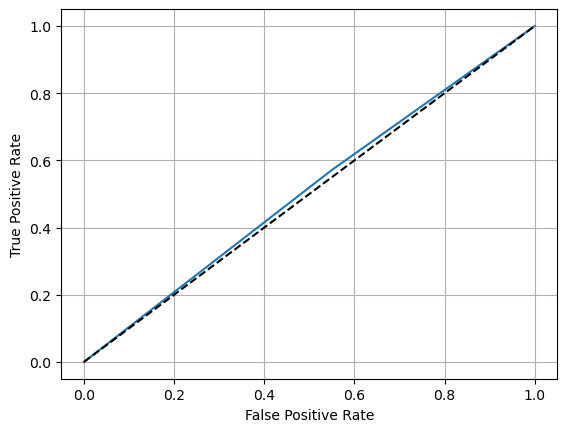

In [470]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [471]:
roc_auc_score(y_test, y_test_pred)

0.5107142857142857

In [472]:
import sys
sys.path.append("../../")
from profit import calc_profit

In [473]:
buy_dates = []
sell_dates = []
is_holding_shares = False
for i, date in enumerate(test_df.index):
    if is_holding_shares:
        if y_test_pred[i] == False:
            sell_dates.append(date)
            is_holding_shares = False
    else:
        if y_test_pred[i] == True:
            buy_dates.append(date)
            is_holding_shares = True
            
buy_dates = pd.DatetimeIndex(buy_dates)
sell_dates = pd.DatetimeIndex(sell_dates)

buy_dates, sell_dates

(DatetimeIndex(['2022-06-27', '2022-07-01', '2022-07-11', '2022-07-13',
                '2022-07-18', '2022-07-22', '2022-07-26', '2022-08-02',
                '2022-08-05', '2022-08-09', '2022-08-15', '2022-08-19',
                '2022-08-25', '2022-08-30', '2022-09-07', '2022-09-13',
                '2022-09-20', '2022-09-29', '2022-10-04', '2022-10-11',
                '2022-10-17', '2022-10-21', '2022-10-26'],
               dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2022-06-28', '2022-07-05', '2022-07-12', '2022-07-14',
                '2022-07-20', '2022-07-25', '2022-07-29', '2022-08-04',
                '2022-08-08', '2022-08-12', '2022-08-17', '2022-08-24',
                '2022-08-29', '2022-09-02', '2022-09-12', '2022-09-19',
                '2022-09-27', '2022-10-03', '2022-10-10', '2022-10-13',
                '2022-10-18', '2022-10-25', '2022-10-27'],
               dtype='datetime64[ns]', freq=None))

In [474]:
profit_rate = calc_profit(stock, buy_dates, sell_dates, start_date="2022-06-27")
print(f"{100 * profit_rate:.2f}%")

2.84%
